# MNE-BIDS pipeline
>
#### This document will serve as a step-by-step guide to walk you through transforming your EEG dataset into one compliant with the BIDS format, using MNE-BIDS.

### What is MNE?
> MNE is an open source python package for working with EEG and MEG data, which serves to facilitate the exploration, visualisation and analysis of neuroimaging data.

### What is BIDS?
> BIDS (Brain Imaging Data Structure) is a simple method of organising neuroimaging data that is easy to adopt and promotes standardisation across neuroimaging experiments. This allows for easier, more open data sharing and collaboration.
>
> It involves a hierarchical folder organisation structure, with four main levels:
>
> ![BIDS hierarchy.png](<attachment:BIDS hierarchy.png>)
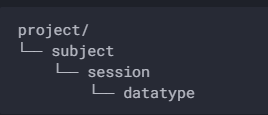

## SO, MNE-BIDS...?
> Is a processing pipeline that uses MNE-python tools to generate BIDS compliant datasets!
>
If you don't currently have MNE-BIDS installed, please refer to their official [website](https://mne.tools/mne-bids-pipeline/stable/getting_started/install.html) to do so before beginning this walkthrough.

# What versions will this document use?

#### - MNE version: 1.9.0
#### - BIDS version: 1.10.0
#### - MNE-BIDS version: 0.16.0

------

# Expected Proficiencies
> #### Prior to using this pipeline, a certain level of understanding/ skill is expected. 

This entails:
- Some knowledge of python (to understand and implement the present code), although this will be explained throughout.
- An understanding of what a BIDS formatted dataset should include and how it should look (for checking the dataset has converted correctly).
  > This information can be found on the [BIDS website](https://bids.neuroimaging.io/getting_started/index.html).
- Familiarity with your EEG dataset and its associated metadata (to ensure all important information is present post-conversion and add any that is missing).

-----

# 1. Downloading data
> #### Collecting the EEG dataset necessary to run through this pipeline

In order to complete this pipeline, you will first need some EEG data. If you intend to run this pipeline using your pre-existing dataset, you can simply move onto the next step. If you don't have any EEG data to test this process on, we suggest downloading the [EEG Motor Movement/Imagery Dataset](https://physionet.org/content/eegmmidb/1.0.0/) from the [Physiobank Database](https://physionet.org/data/). 

[Link this to all of the rest of the document (edit the files to fit it in)]

GIVE LINK TO DOWNLOAD FULL CODE FROM DOC just like MNE does [At bottom]

# 2. Data formatting
> #### This pipeline's data format expectations

This pipeline is curated to work with EEGLab (brainvision and _EDF_ are recommended by MNE) formatted datasets, however MNE is capable of handling a variety of formats. 
>  If your data is currently in a different format, you will need to use a slightly different section of code when reading in your data (step 6). For guidance on this, refer to MNE's documentation on [importing data from EEG devices](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html#sphx-glr-auto-tutorials-io-20-reading-eeg-data-py) for guidance. 
>
The pipeline will also write the dataset into a BIDS-recommended format [EEGLab or BrainVision or EDF] in step 7. If you require a different output format, you may edit the `format` parameter of `write_raw_bids` using [MNE's guidance](https://mne.tools/mne-bids/stable/generated/mne_bids.write_raw_bids.html).

USE THE DATA FORMAT OF THE PHYSIOBANK ONE ONCE SWITCHED OVER (EDF????)

------

# 3. Importing the necessary tools
>### To begin, we will need to import all the tools necessary for converting the data.

This first section of code will import tools that allow us to work with the file paths and simplify the method of handling them.

In [ ]:
#Allows us to work with file paths
import os.path as op
#Makes file path handling simpler
from pathlib import Path

Next, we need to `import MNE`, a python package for working with EEG and MEG data, and some associated tools that we will use here. 
>
From `mne_bids`, we are importing:
- `BIDSPath`:
A tool for creating a BIDS formatted file path
- `print_dir_tree`:
A tool for presenting the contents of a folder in a 'tree' view
- `write_raw_bids`:
A tool for saving EEG data into BIDS format
>
Additionally, we wil be installing MNE-BIDS using [pip](https://pypi.org/project/pip/) (a package installer), before ensuring that MNE-BIDS is upgraded to be the newest version, to allow smooth functionality.

In [ ]:
import mne
%pip install mne_bids
%pip install --upgrade mne_bids

from mne_bids import BIDSPath, print_dir_tree, write_raw_bids, make_dataset_description, update_sidecar_json

------

# 4. Finding the data
>### After completing our imports, we need to find the EEG data files.

In the code below, the first line specifies where the folders and sub-folders for the data can be found. These should include your EEG data and any additional information (metadata). 
>
You should modify this to include your own file pathway: `data_dir = Path(r"___your file pathway____")`. This should be the file containing your task files, or the highest file level containing your dataset and no external (dataset-unrelated) files.
> Here, the `r` (raw) ensures the file location is read as is, and that the backslashes don't get interpreted as special characters, so don't break up the text.
>
The line below this prints a visualisation of the first sub-folders within (using the `print_dir_tree` tool!). 
> You may have 1 or more of these, depending on how much EEG data you wish to make BIDS compliant. Each of these should contain EEG data from one specific task type, including data from each participant and any associated metadata.

In [ ]:
#Change the file path to your data's location
data_dir = Path(r"C:\N8_internship_code\source_data")
print_dir_tree(data_dir, max_depth=1)

This next section lists the file paths for the sub-folders we just visualised and adds them to the list 'children'.

In [ ]:
children = [child for child in data_dir.iterdir()]
children

------

# 5. Selecting specific files
>### Let's specify the files we want to use

Here, the first line serves to identify which of the two files we want to write into BIDS format (note: in python, the first index is given a value of 0). If you have multiple files, each time you run through this you should change the number at the end to match the file you are wanting to adapt. 
>
The second line lists all the files in the specified subfolder.

In [ ]:
#Change this to match the file number
dir_number = 0
files = [file for file in children[dir_number].iterdir()]

This sets the first file in the folder to the variable `file_path`, then prints this. 
>
Even when completing multiple iterations (for more than one dataset), the value should NOT be changed from 0!

In [ ]:
file_path = files[0]
file_path

-------

# 6. Reading the data
>### Now we've completed our preparations, lets compile our data

Here, we are reading the EEG data from the previously selected file path to the `data` variable.
>
As previously mentioned, the current code is tailored to EEGLab formatted datasets and won't work with any other formats. As such, you must use a slightly different line of code depending on the format of your data. 

In [ ]:
data = mne.io.read_raw_eeglab(file_path)

In [ ]:
data

Here, we will specify the line frequency for the dataset, as required by BIDS. You should change the number here to reflect the line frequency of your dataset.

In [ ]:
#specify line frequency
data.info["line_freq"] = 50

How to add montage here

Printing `data` will display the data's information. 

This next section of code will create a new folder path for storing EEG data in BIDS format, then prints it out. 
>
We recommend renaming your file to something more specific to your dataset, by switching out the text in the quotation marks (`"bids_example"`). Attempt to avoiding using any spaces in the title to prevent possible later complications.

In [ ]:
bids_root = op.join(data_dir.parent, "bids_example")
bids_root

-------

# 7. Writing the data
> #### Let's write our selected data into BIDS format!

First, you should manually define the partricipant number/ subject id and task name for this dataset, setting them each to a variable as seen in the first two rows.
>
Then, using the `BIDSPath` tool we imported earlier, we will assign the subject, task and the folder path we just created to `bids_path`. 
>
We will then use another imported tool, `write_raw_bids` to write the data (from the file path we defined earlier) into the new file path we created, linking it to the subject id and task type we outlined. The desired format of the output data is also outlined here `format="EEGLAB"`.

In [ ]:
#Edit this information ot match your data
subject_id = "001"
task = "rest"

bids_path = BIDSPath(subject=subject_id, task=task, root=bids_root)
write_raw_bids(data, bids_path, overwrite=True, allow_preload=True, format="EEGLAB")

_______

### Now you have formatted your dataset to BIDS standards! 
#### Don't forget to repeat steps 4 and 5 for all of the file paths we found in step 3
>
## But hold on!
#### Your BIDS formatted dataset isn't quite complete yet...

-----

# Editing and checking your BIDS formatted dataset
### The steps below will walk you through finding and editing some of the files in your new dataset, in order to make them BIDS-compliant. 
Each of these files should automatically include a large amount of information derived from your dataset and stored in BIDS format, however this may not always be completely accurate.
>
As such, the next steps will walk you through checking that your BIDS dataset is accurate, and how to adapt these files if necessary. Some of the file's items will be deemed required for a BIDS-compliant dataset, while others are recommended or merely optional. You __MUST__ ensure that the required elements are present and have correct data, and although not necessary, it will be beneficial for you to include as much additional data as possible, especially if it is important information for your dataset.

You can do this by navigating to the file path we assigned to the variable `bids_root` in step 4, then working through all of the files and investigating what is present/correct.

# Editing different file formats
Some of the following files will follow the .json format (Sidecar, Coordinate System, Dataset Description), others (Channels Description, Electrodes description) will be in the .tsv format, and a few will have a file in each format (Events, Participants).

These file types are each edited via slightly different methods, so while .json files require no extra imports, to edit our .tsv files we must import the [pandas](https://pandas.pydata.org/pandas-docs/version/1.4/index.html) library.

Due to the differences in their display formats (text vs tabular), while .json files can be edited using a simple dictionary of key:value pairs, editing .tsv files requires a few different code functions. 

Those outlined in this document will walk you through:
- Adding/ Editing a column
- Editing the value of just one row
- Removing a row
- Adding a row



In [ ]:
# Importing the pandas library to edit .tsv files
import pandas as pd

----

# File 1. Sidecar.json
>
This file's name should have a naming format simlilar to *_eeg.json in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through its parameters. Below is a list of information BIDS needs/suggests for this file. 
> Take note of any elements that are missing/incorrect; these can be updated using the next section of code.
>
#### BIDS components:
>
Necessary:
>
    1. EEGReference
    2. SamplingFrequency
    3. PowerlineFrequency
    4. SoftwareFilters
    5. TaskName
>
Recommended:
>
    6. TaskDescription
    7. Instructions
    8. CogAtlasID
    9. CogPOID
    10. CapManufacturer
    11. CapManufacturer'sModelName
    12. SoftwareVersions
    13. DeviceSerialNumber
    14. EEGChannelCount
    15. ECGChannelCount
    16. EMGChannelCount
    17. EOGChannelCount
    18. MISCChannelCount
    19. TriggerChannelCount
    20. RecordingDuration
    21. RecordingType
    22. EpochLength
    23. EEGGround
    24. HeadCircumference
    25. EEGPlacementScheme
    26. HardwareFilters
    27. SubjectArtefactDescription
    28. InstitutionName
    29. InstitutionAddress
    30. InstitutionalDepartment Name
>
Optional:
>
    31. ElectricalStimulation
    32. ElectricalStimulationParameters



## Manually updating an element in the JSON file. 
>
To begin, you must edit the first line of code to match your file path `Path(r'___Your file path here___')`, and the second line to match your files directory `root = (r'__Your file directory here__')`. Additionally, you must change the `subject=` and `task=` sections of `bids_path1` to match your dataset's file name.

Once these are re-defined, you can update one or more aspect(s) of the sidecar using the `entries = {}` dictionary. This accepts `key:value` pairs, separated by colons (:), wherein single quotation marks ('') indicate a parameter name, while double quotation marks ("") indicate it's data entry.
>
##### The code below will display an example of a few formats the key-value pairs can present in, such as:
__Numerical__
    - A key-value pair where the value is a number (int/float).
>
__Written__
    - A key-value pair where the value is a string (text).
>
__Nested dictionary (1 level)__
    - A key-value pair where the value is a dictionary containing key-value pairs.
>
__Nested dictionary (2+ levels)__
    - A key-value pair where the value is a dictionary that contains one or more dictionaries.
>

 > An example output file can be found within the [BIDS documentation](https://bids-specification.readthedocs.io/en/stable/modality-specific-files/electroencephalography.html).

In [ ]:
#updating a specific parameter in the sidecar JSON file
json_file = Path(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_eeg.json').absolute()
# Create BIDSPath using the JSON file's directory as root
root = (r'C:\N8_internship_code\bids_example')

bids_path1 = BIDSPath(subject='001', task='rest',
                     suffix='eeg', extension='.json', datatype='eeg',
                     root=root)

entries = {# Simple key-value pair for power line frequency (numerical)
           'PowerLineFrequency': 50.0,
           # Simple key-value pair for task name (written)
            'TaskName': "Resting State",
            # Nested dictionary for software versions (1-level)
            'SoftwareVersions' : {
                'MNE': "1.9.0",
                'BIDS': "1.10.0",
                'MNE-BIDS': "0.16.0"
                },
           # Nested dictionary for software filters (2-levels)
           'SoftwareFilters': {
                "Anti-aliasing filter":{
                "half-amplitude cutoff (Hz)": 500,
                "Roll-off": "6dB/Octave"
                }
                },
            }   

# Update the JSON file with your new entries
update_sidecar_json(bids_path1, entries, verbose=True)

----

# File 2. Channels Description
>
This should have a format simlilar to *_channels.tsv in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through the components it lists. Below is a list of information BIDS needs/suggests for this file. Take note of which elemets are missing or incorrect.
>
#### BIDS components:
>
Necessary:
>
    1. Name
    2. Type
    3. Units
Recommended
>
    n/a
>
Optional:
>
    4. Description
    5. SamplingFrequency
    6. Reference
    7. LowCutoff
    8. HighCutoff
    9. Notch
    10. Status
    11. StatusDescription

## Manually updating the channels.tsv file:
To edit this file, we must first edit the file path in the single quotation marks ('') to match the location of your `channels.tsv` file. 

This will ensure that the variable `channels_tsv` refers to the file we're working with.

In [ ]:
# Assigning the channels.tsv file to a variable
channels_tsv = pd.read_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_channels.tsv', sep='\t')

#### Adding/ Editing a column:

Both of these functions can be managed using the same section of code!

First, you should edit the 'Inputs' list to include the variables you wish to add to your new or pre-existing column. This should be done in participant order, beginning with the entry for the first participant in the file, and an entry must be submitted for each row.

Then, you should change the text in double quotation marks ("") within `channels_tsv["__"]`, to either title of the pre-existing column you wish to add to, or the title of the new column you wish to generate.

Next, you should edit the file paths in the single quotation marks ('') to the location of your `channels.tsv` file, as we did above. This ensures that the code knows what file it's writing to.

In [ ]:
# Listing the desired inputs for the "status" column
Inputs = ["Good", "Bad", "Average"]  

# Setting the rows in the "status" column to the inputs listed above
channels_tsv["status"] = Inputs

#writing the change to the file
channels_tsv.to_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_channels.tsv', sep= '\t', index=False, na_rep='n/a')


#### Editing one row:
 
To edit a single row, you must use the `.loc` function, which allows us to select a row via it's label. In this case, we will use 'name', by editing the name of the channel (in the second set of double quotation marks) to match that of the row you'd like to edit. 

From there, you can edit the column name to match the one you'd like to edit (in the third set of double quotation marks) and then the item you;d like to assign to the location (in the fourth set of double quotation marks).

Then, after changing file location in the last line to match your own, we can write the changes to the file.

In [ ]:
# Editing just one row in the channels.tsv file
channels_tsv.loc[channels_tsv["name"] == "Fp1", "status"] = "good"

# Writing the change to the file
channels_tsv.to_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_channels.tsv', sep= '\t', index=False, na_rep='n/a')

#### Removing a row:

To remove a row, you must use the `.drop` function, to which you assign an index, which is the number assigned to the row you wish to remove. 
Note: Indexes begin from 0, so the 'first' row will be #0, the 'second' row will be #1 and so on.

Then, after the file location in the last line has been changed to match your own, we can write the changes to the file.

In [ ]:
# Removing a row from the channels.tsv file using the row's index
channels_tsv = channels_tsv.drop(index=1)

# Writing the change to the file
channels_tsv.to_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_channels.tsv', sep= '\t', index=False, na_rep='n/a')

#### Adding a row:

To add a row, you must first create a new data frame containing all of the columns and their values (in key:value pairs) that you want to add to the new row (do so by editing the text in the double quotation marks in the first line, and adding new key:value pairs where necessary). 

This will then be combined with the current data frame (channels_tsv), and once you have changed the file location in the last line to match your own, these edits can be written to the file.

In [ ]:
# Creating a new data frame for the new row
new_channels_row = pd.DataFrame([{"name": "F3", "type": EEG, "units":"V"}])

# Combining the new row with the existing channels_tsv data frame
channels_tsv = pd.concat([channels_tsv, new_channels_row], ignore_index=True)

# Writing the change to the file
channels_tsv.to_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_channels.tsv', sep= '\t', index=False, na_rep='n/a')

----

# File 3. Electrodes Description 
This should have a format simlilar to *_electrodes.tsv in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through the components it lists. Below is a list of information BIDS needs/suggests for this file. Take note of which elemets are missing/incorrect.
>
#### BIDS components:
>
Necessary:
>
    1. X
    2. Y
    3. Z
>
Recommended:
>
    4. Type
    5. Material
    6. Impedance
>
Optional:
>
    n/a

## Manually updating the electrodes.tsv file:
To edit this file, we must first edit the file path in the single quotation marks ('') to match the location of your `electrodes.tsv` file. 

This will ensure that the variable `electrodes_tsv` refers to the file we're working with.

In [ ]:
# Assigning the electrodes.tsv file to a variable
electrodes_tsv = pd.read_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_space-CapTrak_electrodes.tsv', sep='\t')

#### Adding/ Editing a column:

Both of these functions can be managed using the same section of code!

First, you should edit the 'Inputs' list to include the variables you wish to add to your new or pre-existing column. This should be done in participant order, beginning with the entry for the first participant in the file, and an entry must be submitted for each row.

Then, you should change the text in double quotation marks ("") within `electrodes_tsv["__"]`, to either title of the pre-existing column you wish to add to, or the title of the new column you wish to generate.

Next, you should edit the file paths in the single quotation marks ('') to the location of your `electrodes.tsv` file, as we did above. This ensures that the code knows what file it's writing to.

In [ ]:
# Listing the desired inputs for the "z" column
Inputs = ["0.0", "0.049", "-0.039", "0.07"]  

# Setting the rows in the "z" column to the inputs listed above
participants_tsv["z"] = Inputs

# Writing the change to the file
participants_tsv.to_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_space-CapTrak_electrodes.tsv', sep= '\t', index=False, na_rep='n/a')

#### Editing one row:
 
To edit a single row, you must use the `.loc` function, which allows us to select a row via it's label. In this case, we will use participant ID, by editing the participant ID number (in the second set of double quotation marks) to match that of the row you'd like to edit. 

From there, you can edit the column name to match the one you'd like to edit (in the third set of double quotation marks) and then the item you;d like to assign to the location (in the fourth set of double quotation marks).

Then, after changing file location in the last line to match your own, we can write the changes to the file.

In [ ]:
# Editing just one row in the participants.tsv file
participants_tsv.loc[participants_tsv["participant_id"] == "sub-001", "Education"] = "none"

# Writing the change to the file
participants_tsv.to_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_space-CapTrak_electrodes.tsv', sep= '\t', index=False, na_rep='n/a')

#### Removing a row:

To remove a row, you must use the `.drop` function, to which you assign an index, which is the number assigned to the row you wish to remove. 
Note: Indexes begin from 0, so the 'first' row will be #0, the 'second' row will be #1 and so on.

Then, after the file location in the last line has been changed to match your own, we can write the changes to the file.

In [ ]:
# Removing a row from the participants.tsv file using the row's index
participants_tsv = participants_tsv.drop(index=1)

# Writing the change to the file
participants_tsv.to_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_space-CapTrak_electrodes.tsv', sep= '\t', index=False, na_rep='n/a')

#### Adding a row:

To add a row, you must first create a new data frame containing all of the columns and their values (in key:value pairs) that you want to add to the new row (do so by editing the text in the double quotation marks in the first line, and adding new key:value pairs where necessary). 

This will then be combined with the current data frame (participants_tsv), and once you have changed the file location in the last line to match your own, these edits can be written to the file.

In [ ]:
# Creating a new data frame for the new row
new_participants_row = pd.DataFrame([{"participant_id": "sub-002", "age": 30, "sex":"M"}])

# Combining the new row with the existing participants_tsv data frame
participants_tsv = pd.concat([participants_tsv, new_participants_row], ignore_index=True)

# Writing the change to the file
participants_tsv.to_csv(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_space-CapTrak_electrodes.tsv', sep= '\t', index=False, na_rep='n/a')

----

# File 4. Coordinate System
This should have a naming format simlilar to *_coordsystem.json in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through its parameters. Below is a list of information BIDS needs/suggests for this file. 
>Take note of any elements that are missing/incorrect; these can be updated using the next section of code.

#### BIDS components:
>
Necessary:
>
    1. EEGCoordinateSystem
    2. EEGCoordinateUnits
    3. EEGCoordinateSystemDescription
Recommended:
>
    4. FiducialsDescription
    5. FiducialsCoordinates
    6. FiducialsCoordinateSystem
    7. FiducialsCoordinateUnits
    8. FiducialsCoordinateSystemDescription
    9. AnatomicalLandmarkCoordinates
    10. AnatomicalLandmarkCoordinateSystem
    11. AnatomicalLandmarkCoordinateUnits
    12. AnatomicalLandmarkCoordinateSystemDescription
>
Optional:
>
    13. IntendedFor

## Manually updating an element in the JSON file
As with the sidecar file, the first line of code should be edited to match your file path `Path(r'___Your file path here___')`, and the second line to match your files directory `root = (r'__Your file directory here__')`. Additionally, you must change the `subject=` and `space=` sections of `bids_path1` to match your dataset's file name.

For this file, the `space=` section is defined as CapTrak; if you were using a different coordinate system, its name should be inputted here instead.

Once these are re-defined, you can update one or more aspect(s) of the sidecar using the `entries = {}` dictionary. This accepts `key:value` pairs, separated by colons (:), wherein single quotation marks ('') indicate a parameter name, while double quotation marks ("") indicate it's data entry.
>
##### The code below will display an example of a few formats the key-value pairs can present in, such as:
>
__Written__
    - A key-value pair where the value is a string (text).
>
__Nested dictionary (1 level)__
    - A key-value pair where the value is a dictionary containing key-value pairs.
>
- Note: This file will accept key-value pairs in other formats, but those represented here are the only formats _necessary_.

> An example output file can be found within the [BIDS documentation](https://bids-specification.readthedocs.io/en/stable/modality-specific-files/electroencephalography.html).

In [ ]:
# Updating a specific parameter in the coordinate system JSON file
json_file = Path(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_space-CapTrak_coordsystem.json').absolute()
# Create BIDSPath using the JSON file's directory as root
root = Path(r'C:\N8_internship_code\bids_example')


bids_path1 = BIDSPath(subject='001', task=None,
                     suffix='coordsystem', extension='.json', datatype='eeg',
                     root=root, space='CapTrak')

entries = { # Simple key-value pair for EEG Coordinate System (written)
            'EEGCoordinateSystem':"CapTrak",
            # Nested dictionary for Anatomical Landmark Coordinates, with list values (1-level)
            'AnatomicalLandmarkCoordinates': {
                'Nasion': [0.0, 0.0, 0.0],
                'Left Preauricular': [-0.1, 0.0, 0.0],
                'Right Preauricular': [0.1, 0.0, 0.0]
            },
            }       
# Update the JSON file with your new entries
update_sidecar_json(bids_path1, entries, verbose=True)

----

# File 5. Events.tsv

# File 6. Events.json
This file's name should have a format simlilar to *_events.json in your 'eeg' subfolder. 

Once you have located the file, you should open it and look through its parameters. Below is a list of information BIDS needs/suggests for this file. 
> Take note of any elements that are missing/incorrect; these can be updated using the next section of code.
>
#### BIDS components:
>
Necessary:
>
    1. Onset
    2. Duration
>
Recommended:
>
    n/a
>
Optional:
>
    3. TrialType
    4. ResponseTime
    5. HED
    6. StimFile
    7. Channel
>

## Manually editing an element in the JSON file
Similarly to the procedure for the other JSON files, the first line of code should be edited to match your file path `Path(r'___Your file path here___')`, and the second line to match your files directory `root = (r'__Your file directory here__')`. Additionally, you must change the `subject=` and `task=` sections of `bids_path1` to match your dataset's file name.

Once these are re-defined, you can update one or more aspect(s) of the sidecar using the `entries = {}` dictionary. This accepts `key:value` pairs, separated by colons (:), wherein single quotation marks ('') indicate a parameter name, while double quotation marks ("") indicate it's data entry.
>
##### The code below will display an example of a few formats the key-value pairs can present in, such as:
__Nested dictionary (1 level)__
    - A key-value pair where the value is a dictionary containing key-value pairs.
>
__Nested dictionary (2+ levels)__
    - A key-value pair where the value is a dictionary that contains one or more dictionaries.
>

- Note: This file will accept key-value pairs in other formats, but those represented here are the most common.

 > An example output file can be found within the [BIDS documentation](https://bids-specification.readthedocs.io/en/stable/modality-specific-files/electroencephalography.html).


In [ ]:
# Updating a specific parameter in the events JSON file
json_file = Path(r'C:\N8_internship_code\bids_example\sub-001\eeg\sub-001_task-rest_events.json').absolute()
# Create BIDSPath using the JSON file's directory as root
root = (r'C:\N8_internship_code\bids_example')


bids_path1 = BIDSPath(subject='001', task='rest',
                     suffix='events', extension='.json', datatype='eeg',
                     root=root)

entries = {# Nested dictionary for event duration containing description and units (1-level)
        'Duration':{'Description': "Duration of the event in seconds.", 'Units': "Seconds"},
         # Nested dictionary for trial type containing name, description, and levels (2-levels)
        'TrialType':{'Name':"Event Category", 
                     'Description': "Indicator of the type of action that is expected.", 
                     'Levels': {
                        'Start': "A red square appears on the screen to indicate the start of a trial.",
                        'Stop': "A green square appears on the screen to indicate the end of a trial"}
                     },
         # Nested dictionary for stim file containing description, file type, and file path (1-level)
        'Stim File': {'Description': "File containing the stimulus presentation information for the event.", 'FileType': "CSV", 'FilePath': "sub-001_task-rest_stim.csv"},
        }     
# Update the JSON file with your new entries  
update_sidecar_json(bids_path1, entries, verbose=True)

----

# File 7. Dataset Description
Now we can move on to the more general, yet equally as important information files. 
>
The code below will re-write the ENTIRE dataset description, overwriting any previous dataset description files.
This file should describe the dataset in as much detail as possible, so you should attempt to include as much of the data outlined below as possible although BIDS only requires the presence of the 'necessary' information.

#### BIDS components:
>
Necessary:
>
    1. StudyName
    2. BIDSVersion 
>
Recommended:
>
    3. HEDVersion
    4. DatasetType
    5. DataLicense
    6. Authors
    7. GeneratedBy
        - Name
        - Version
        - Container
        - Type
        - Tag
    8. SourceDatasets
>
Optional:
>
    9. Acknowledgements
    10. HowToAcknowledge
    11. Funding
    12. EthicsApprovals
    13. ReferencesAndLinks
    14 Doi
Note: `BIDS version` will be automatically included in the data file once the code is run.


Once you have decided on the information you wish to include, you can append the code below, changing the information in quotation marks to your dataset's information.
>
Any that you don't intend on including should be written as `<item>=None`, just as `acknowledgements` is below. This will skip that item, preventing its inclusion in the file. 
> This code will overwrite any 'dataset description' file previously generated. This can be changed by changing `overwrite=True` to `overwrite=False`. 
>
- Note: Doi must be written in the format: `doi:<insert_doi>`.

> An example output file can be found within the [BIDS documentation](https://bids-specification.readthedocs.io/en/stable/modality-agnostic-files.html).

In [ ]:
# Creating a dataset description JSON file
# Will overwrite any existing dataset_description.json file in the root of the BIDS directory
make_dataset_description(
    path=bids_root,
    name="EEGManyLabs Resting State Study", 
    hed_version="1",
    dataset_type='raw',
    data_license="CCO",
    authors=["Ariana Williams", "Daniel Brady"],
    generated_by=[
        {
            "Name": "MNE-BIDS",
            "Version": "0.14",
            "Description": "Used to convert MEG data into BIDS format."
        },
        {
            "Name": "MNE-Python",
            "Version": "1.6.1",
            "Description": "Used for MEG preprocessing and analysis."
        }
    ],
    source_datasets=[
        {
            "URL": "https://example.com/source_dataset",
            "DOI": "10.1234/example.doi",
        }],
    acknowledgements=None,
    how_to_acknowledge="Cite (Williams et al., 2025) when using this dataset",
    funding=["The NHS", "The Uk government"],
    ethics_approvals="Ethical approval was granted by the University of Leeds School of Psychology Ethics committee (12345 2025)",
    references_and_links="https://mne.tools/mne-bids/stable/whats_new_previous_releases.html",
    doi="doi:https://doi.org/10.1016/j.tins.2017.02.004",
            overwrite=True,
            verbose=True)

----

# File 8. Participants.tsv
The participants.tsv file includes a table containing participant information relavant to the dataset. It is accompanied by the participants.json file, which provides more in-depth explanations for this information.
>
MNE-BIDS will automatically input the majority of this information, but you may wish to edit the file in order to add more columns to include further participant information.

#### BIDS Components:
>
Necessary:
>
    1. Participant ID 
>
Recommended:
>
    2. Species
    3. Age
    4. Sex
    5. Handedness
    6. Strain
    7. Strain RRID
>
Optional:
>
    - Additional participant information may be included to further bolster your metadata.

## Manually updating the participants.tsv file:
To edit this file, we must first edit the file path in the single quotation marks ('') to match the location of your `participants.tsv` file. 

This will ensure that the variable `participants_tsv` refers to the file we're working with.

In [ ]:
# Assigning the participants.tsv file to a variable
participants_tsv = pd.read_csv(r'C:\N8_internship_code\bids_example\participants.tsv', sep='\t')

#### Adding/ Editing a column:

Both of these functions can be managed using the same section of code!

First, you should edit the 'Inputs' list to include the variables you wish to add to your new or pre-existing column. This should be done in participant order, beginning with the entry for the first participant in the file, and an entry must be submitted for each row.

Then, you should change the text in double quotation marks ("") within `participants_tsv["__"]`, to either title of the pre-existing column you wish to add to, or the title of the new column you wish to generate.

Next, you should edit the file paths in the single quotation marks ('') to the location of your `participants.tsv` file, as we did above. This ensures that the code knows what file it's writing to.

In [ ]:
# Listing the desired inputs for the "Education" column
Inputs = ["High School", "A-level", "Bachelors", "PhD"]  

# Setting the rows in the "Education" column to the inputs listed above
participants_tsv["Education"] = Inputs

# Writing the change to the file
participants_tsv.to_csv(r'C:\N8_internship_code\bids_example\participants.tsv', sep= '\t', index=False, na_rep='n/a')

#### Editing one row:
 
To edit a single row, you must use the `.loc` function, which allows us to select a row via it's label. In this case, we will use participant ID, by editing the participant ID number (in the second set of double quotation marks) to match that of the row you'd like to edit. 

From there, you can edit the column name to match the one you'd like to edit (in the third set of double quotation marks) and then the item you;d like to assign to the location (in the fourth set of double quotation marks).

Then, after changing file location in the last line to match your own, we can write the changes to the file.

In [ ]:
# Editing just one row in the participants.tsv file
participants_tsv.loc[participants_tsv["participant_id"] == "sub-001", "Education"] = "none"

# Writing the change to the file
participants_tsv.to_csv(r'C:\N8_internship_code\bids_example\participants.tsv', sep= '\t', index=False, na_rep='n/a')

#### Removing a row:

To remove a row, you must use the `.drop` function, to which you assign an index, which is the number assigned to the row you wish to remove. 
Note: Indexes begin from 0, so the 'first' row will be #0, the 'second' row will be #1 and so on.

Then, after the file location in the last line has been changed to match your own, we can write the changes to the file.

In [ ]:
# Removing a row from the participants.tsv file using the row's index
participants_tsv = participants_tsv.drop(index=1)

# Writing the change to the file
participants_tsv.to_csv(r'C:\N8_internship_code\bids_example\participants.tsv', sep= '\t', index=False, na_rep='n/a')

#### Adding a row:

To add a row, you must first create a new data frame containing all of the columns and their values (in key:value pairs) that you want to add to the new row (do so by editing the text in the double quotation marks in the first line, and adding new key:value pairs where necessary). 

This will then be combined with the current data frame (participants_tsv), and once you have changed the file location in the last line to match your own, these edits can be written to the file.

In [ ]:
# Creating a new data frame for the new row
new_participants_row = pd.DataFrame([{"participant_id": "sub-002", "age": 30, "sex":"M"}])

# Combining the new row with the existing participants_tsv data frame
participants_tsv = pd.concat([participants_tsv, new_participants_row], ignore_index=True)

# Writing the change to the file
participants_tsv.to_csv(r'C:\N8_internship_code\bids_example\participants.tsv', sep= '\t', index=False, na_rep='n/a')

----

# File 9. Participants.json
The participants.json file exists as a counterpart to the participants.tsv file and is used to describe the TSV column names and the properties of their values, making interpretation easier, especially in the case of dataset-specific columns. 
>
MNE-BIDS will automatically input the majority of this information, but you may wish to edit these descriptions to be more accurate, and should add additional descriptions for each new parameter added to the participants.tsv file (e.g. education level).

#### BIDS Components:
>
Necessary:
>
    1. Participant ID 
>
Recommended:
>
    2. Species
    3. Age
    4. Sex
    5. Handedness
    6. Strain
    7. Strain RRID
>
Optional:
>
    - Additional participant information may be included to further bolster your metadata.

## Manually updating an element in the participants.json file: 
>
To begin, you must edit the first line of code to match your file path `Path(r'___Your file path here___')`, and the second line to match your files directory `root = (r'__Your file directory here__')`.

Once these are re-defined, you can update one or more aspect(s) of the sidecar using the `entries = {}` dictionary. This accepts `key:value` pairs, separated by colons (:), wherein single quotation marks ('') indicate a parameter name, while double quotation marks ("") indicate it's data entry.
>
##### The code below will display an example of a few formats the key-value pairs can present in, such as:
>
__Nested dictionary (1 level)__
    - A key-value pair where the value is a dictionary containing key-value pairs.
>
__Nested dictionary (2+ levels)__
    - A key-value pair where the value is a dictionary that contains one or more dictionaries.

- Note: This file will accept key-value pairs in other formats, but those represented here are the most common.

> An example output file can be found within the [BIDS documentation](https://bids-specification.readthedocs.io/en/stable/modality-agnostic-files.html).

In [ ]:
#code for adding information to the participants.json file
json_file = Path(r'C:\N8_internship_code\bids_example\participants.json').absolute()
# Create BIDSPath using the JSON file's directory as root
root = (r'C:\N8_internship_code\bids_example')


bids_path1 = BIDSPath(subject=None, task=None,
                     suffix='participants', extension='.json', datatype=None,
                     root=root)

entries = { # Nested dictionary for age containing description and units (1-level)
            'Age': {'Description': "Age of the participant at time of testing", 'Units': "Years"}, 
            # Nested dictionary for handedness containing description and levels (2-levels)
            'Handedness': {'Description': "Handedness of the participant",
                        'Levels': {
                            "R": "Right-handed",
                            "L": "Left-handed",
                            "A": "Ambidextrous"
                        }
                },
        }       
update_sidecar_json(bids_path1, entries, verbose=True)

____

# 10. Phenotype file
https://bids-specification.readthedocs.io/en/stable/modality-agnostic-files.html#phenotypic-and-assessment-data

----

# How to cite MNE-BIDS

#### As we used their tools to generate our BIDS formatted dataset, we must cite MNE-BIDS somewhere within it!
The following code will automatically do this for you:


In [ ]:
readme = op.join(bids_root, "README")
with open(readme, encoding="utf-8-sig") as fid:
    text = fid.read()
print(text)

----

# Our Citations
MNE-BIDS
> Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A., & Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software, 4:1896. DOI: 10.21105/joss.01896
>
>  Pernet, C.R., Appelhoff, S., Gorgolewski, K.J. et al. EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Sci Data 6, 103 (2019). https://doi.org/10.1038/s41597-019-0104-8
>
MNE-Python
> Alexandre Gramfort, Martin Luessi, Eric Larson, Denis A. Engemann, Daniel Strohmeier, Christian Brodbeck, Roman Goj, Mainak Jas, Teon Brooks, Lauri Parkkonen, and Matti S. Hämäläinen. MEG and EEG data analysis with MNE-Python. Frontiers in Neuroscience, 7(267):1–13, 2013. doi:10.3389/fnins.2013.00267.
>
BIDS
> Gorgolewski, K.J., Auer, T., Calhoun, V.D., Craddock, R.C., Das, S., Duff, E.P., Flandin, G., Ghosh, S.S., Glatard, T., Halchenko, Y.O., Handwerker, D.A., Hanke, M., Keator, D., Li, X., Michael, Z., Maumet, C., Nichols, B.N., Nichols, T.E., Pellman, J., Poline, J.-B., Rokem, A., Schaefer, G., Sochat, V., Triplett, W., Turner, J.A., Varoquaux, G., Poldrack, R.A. (2016). The brain imaging data structure, a format for organizing and describing outputs of neuroimaging experiments. Scientific Data, 3 (160044). doi:10.1038/sdata.2016.44
>
>  Pernet, C. R., Appelhoff, S., Gorgolewski, K.J., Flandin, G., Phillips, C., Delorme, A., Oostenveld, R. (2019). EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Scientific data, 6 (103). doi:10.1038/s41597-019-0104-8

-----